In [1]:
import os.path as op

from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
from scipy.signal import spectrogram
from scipy.stats import ttest_rel

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from fooof import FOOOFGroup, FOOOF

from timescales.est.psd import fit_psd, convert_knee_val
from timescales.est.acf import fit_acf, fit_acf_cos, compute_acf, exp_decay_func
from timescales.sim.acf import sim_acf_cos

### Sliding Window Tau

#### Background
This notebook uses fcx-1, from CRCNS, to investigate sliding window tau estimation. This data consists of two cycles, each with ~7 minutes of wake followed by ~20 minutes of sleep. Based on Watson at al. 2016, they show that overall power increases, corresponding to low variance voltage segments, are associated with non-REM episodes. CRCNS provides times of sleep, non-rem, rem, and micro-arousals. Here, we focus on comparing timescales between sleep vs non-rem, since rem and micro arousals periods contain much less data.


#### Method / Results
For the ~54 minutes of interest, a window is slide across the data, with a step size of 1s. Each window contains 5s before and 5s after the current sample. Windows are grouped by wake and non-REM sleep periods. A PSD is computed for each window, and a timescale is determined. The results show that short timescales are associate with non-REM periods and long timescales are associated with wake periods.

#### Discussion
The wake periods tend to have short timescales, but also have lower r-squared values, compared to the non-REM periods. This may mean that there is more noise during the wake periods (i.e. noise from movement) and/or that the Lorenztian isn't the appriopriate model.

Many of the wake timescales appear to be > 1s long (< 1 Hz) and Welch's doesn't provide resolution below 1 Hz which may be something to also consider.

#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
# Load LFP
data_dir = '/home/rph/Projects/timescale-methods/fcx1/data_mats'
lfp_file = op.join(data_dir, 'data18.mat')

fs = 1250
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)
#sig_lfp = filter_signal(sig_lfp, fs, 'lowpass', 200)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, '20140526_277um_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

In [3]:
# Functions
# To-Do: Refactor to import from module

def create_windows(samples, win_len, win_spacing):
    # Determine windows
    win_starts = []

    for lower, upper in samples:
        win_starts.append(np.arange(lower-1, upper, win_spacing) - (win_len//2))

    win_starts = np.concatenate(win_starts)
    mids = win_starts + (win_len//2)

    return win_starts, mids


def sort_result(result):
    
    taus = np.array([r[0] for r in result])
    rsq = np.array([r[1] for r in result])
    result_class = [r[2] for r in result]
    
    return taus, rsq, result_class


def _fit_psd(s, sig_lfp=None, fs=None, win_len=None, compute_spectrum_kwargs=None,
              f_range=None, knee_bounds=None, fooof_init=None, rsq_type='linear'):
    
    if compute_spectrum_kwargs is None:
        compute_spectrum_kwargs = {}
        
    freqs, powers = compute_spectrum(sig_lfp[s:s+win_len], fs, f_range=f_range,
                                     **compute_spectrum_kwargs)
    
    if fooof_init is None:
        fooof_init = dict(max_n_peaks=5, peak_threshold=3,
                          peak_width_limits=(2, 10))
    
    fm, _, kt = fit_psd(freqs, powers, f_range, fooof_init=fooof_init,
                        knee_bounds=knee_bounds, n_jobs=1)
    
    if rsq_type == 'log':
        rsq = fm.r_squared_
    elif rsq_type == 'linear':
        rsq = np.corrcoef(10**fm.power_spectrum, 10**fm.fooofed_spectrum_)[0][1] ** 2
    
    return kt, rsq, fm


class ACF:
    
    def __init__(self, sig, fs):
        self.sig = sig
        self.fs = fs
        
        self.params = None
        self.corrs = None
        self.corrs_fit = None
        self.rsq = None
        
    def compute_acf(self, start, win_len, nlags=None):
        if nlags is None:
            nlags = self.fs
        self.corrs = compute_acf(self.sig[start:start+win_len], nlags)
        
    def fit(self, bounds=None):
        self.params = fit_acf(self.corrs, self.fs, bounds=bounds)
        self.corrs_fit = exp_decay_func(np.arange(1, len(self.corrs)+1),
                                        self.fs, *self.params)
        
        self.rsq = np.corrcoef(self.corrs, self.corrs_fit)[0][1] ** 2
        
    def fit_cos(self, bounds=None):
        self.params = fit_acf_cos(self.corrs, self.fs, bounds=bounds)
        self.corrs_fit = sim_acf_cos(np.arange(1, len(self.corrs)+1), self.fs, *self.params)
        self.rsq = np.corrcoef(self.corrs, self.corrs_fit)[0][1] ** 2
        
def _fit_acf(s, sig_lfp=None, fs=None, nlags=None, win_len=None, bounds=None, method='cos'):
    
    _acf = ACF(sig_lfp, fs)
    _acf.compute_acf(s, win_len, nlags)
    
    if method == 'cos':
        _acf.fit_cos(bounds=bounds)
    elif method == 'decay':
        _acf.fit(bounds=bounds)
    
    return _acf.params[0], _acf.rsq, _acf
    
    
def plot_connected_scatter(taus_a, taus_b, ax, title, ylim=None, ylabel=None):
    
    xs_a = np.random.uniform(1, 1.2, size=len(taus_a))
    ax.scatter(xs_a, taus_a, alpha=.5)


    xs_b = np.random.uniform(1.8, 2, size=len(taus_b))
    ax.scatter(xs_b, taus_b, alpha=.5)

    vp = ax.violinplot([taus_a, taus_b], showextrema=False)
    vp['bodies'][1].set_color('C1')
    vp['bodies'][1].set_facecolor('C1')
    vp['bodies'][1].set_edgecolor('C1')

    b = vp['bodies'][0]
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf,
                                              np.mean(b.get_paths()[0].vertices[:, 0]))

    b = vp['bodies'][1]
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0],
                                              np.mean(b.get_paths()[0].vertices[:, 0]), np.inf)

    for i, (t_psd, t_acf) in enumerate(zip(taus_a, taus_b)):
        ax.plot([xs_a[i], xs_b[i]], [t_psd, t_acf], color='k', alpha=.1)
    
    ax.set_title(title)  
    ax.set_ylabel('Tau')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['PSD', 'ACF'])
    ax.set_xlim(0, 3)
    
    if ylabel is None:
        ax.set_ylabel('Tau')
    else:
        ax.set_ylabel(ylabel)
        
    if ylim is not None:
        ax.set_ylim(ylim)

### SpecParam

In [4]:
# Create windows
win_len = int(20*fs)+1
win_spacing = int(fs * 10)

wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

wake_starts, wake_mids = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids = create_windows(nrem_pad, win_len, win_spacing)

In [5]:
# SpecParam
fit_kwargs = dict(
    sig_lfp=sig_lfp, fs=fs, win_len=win_len, f_range=(0, 80),
    compute_spectrum_kwargs=dict(nperseg=int(2*fs), avg_type='mean'),
    knee_bounds=(.05, 100000), rsq_type='linear'
)

with Pool(processes=6) as pool:
    mapping = pool.imap(partial(_fit_psd, **fit_kwargs), wake_starts, chunksize=20)
    results_wake = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))
    
fit_kwargs = dict(
    sig_lfp=sig_lfp, fs=fs, win_len=win_len, f_range=(0, 80),
    compute_spectrum_kwargs=dict(nperseg=int(2*fs), avg_type='mean'),
    knee_bounds=(.05, 100000), rsq_type='linear'
)


with Pool(processes=6) as pool:
    mapping = pool.imap(partial(_fit_psd, **fit_kwargs), nrem_starts, chunksize=20)
    results_nrem = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
wake_taus, wake_rsq, wake_fms = sort_result(results_wake)
nrem_taus, nrem_rsq, nrem_fms = sort_result(results_nrem)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

### ACF

In [6]:
# ACF
bounds = np.array([[1e-6, None, None],
                   [10, None, None]])

fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, bounds=None,
                  method='decay', nlags=int(1*fs))

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), wake_starts, chunksize=20)
    results_wake_acf = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))
    

fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, bounds=None,
                  method='decay', nlags=int(1*fs))

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(_fit_acf, **fit_kwargs), nrem_starts, chunksize=20)
    results_nrem_acf = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
wake_taus_acf, wake_rsq_acf, wake_acf_class = sort_result(results_wake_acf)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = sort_result(results_nrem_acf)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

### Results

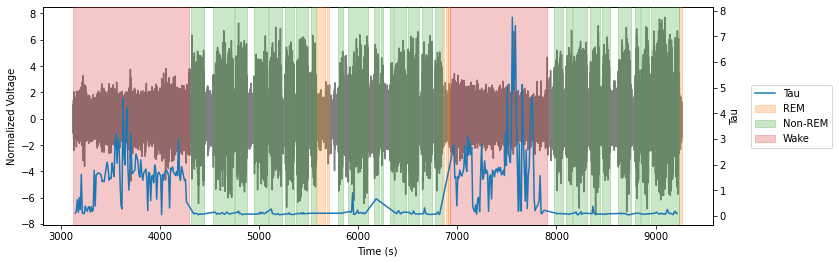

In [7]:
# Determine start and end of lfp
start_ends = [nrem[0][0], nrem[-1][-1], rem[0][0],
              rem[-1][-1], wake[0][0], wake[-1][-1]]

start = min(start_ends)-1
end = max(start_ends)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized Voltage')
ax1.plot(times[start:end], sig_lfp[start:end], label='LFP', color='k', alpha=.5)
ax1.tick_params(axis='y', labelcolor='k')

mids = np.concatenate((wake_mids, nrem_mids)).astype(int)
taus = np.concatenate((wake_taus, nrem_taus))
order = np.argsort(mids)

ax2 = ax1.twinx()
ax2.set_ylabel('Tau')
ax2.plot(times[mids[order]], taus[order], alpha=1, label='Tau', color='C0', zorder=10)
ax2.tick_params(axis='y')

# Color regions
colors = ['C1', 'C2', 'C3']
labels = ['REM', 'Non-REM', 'Wake']

for periods, color, label in zip([rem, nrem, wake], colors, labels):
    for _ind, i in enumerate(periods):
        if _ind == 0:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3, label=label)
        else:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3)
        
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));

In [8]:
# Remove outliers
n_to_keep= round(len(wake_rsq)*.85)
wake_keep = np.argsort(np.abs(wake_taus - wake_taus_acf))[:n_to_keep]

n_to_keep= round(len(nrem_rsq)*.85)
nrem_keep = np.argsort(np.abs(nrem_taus - nrem_taus_acf))[:n_to_keep]

# Run paired t-test
wake_rsq_pval = ttest_rel(wake_rsq[wake_keep], wake_rsq_acf[wake_keep]).pvalue
wake_taus_pval = ttest_rel(wake_taus[wake_keep], wake_taus_acf[wake_keep]).pvalue

nrem_rsq_pval = ttest_rel(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep]).pvalue
nrem_taus_pval = ttest_rel(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep]).pvalue

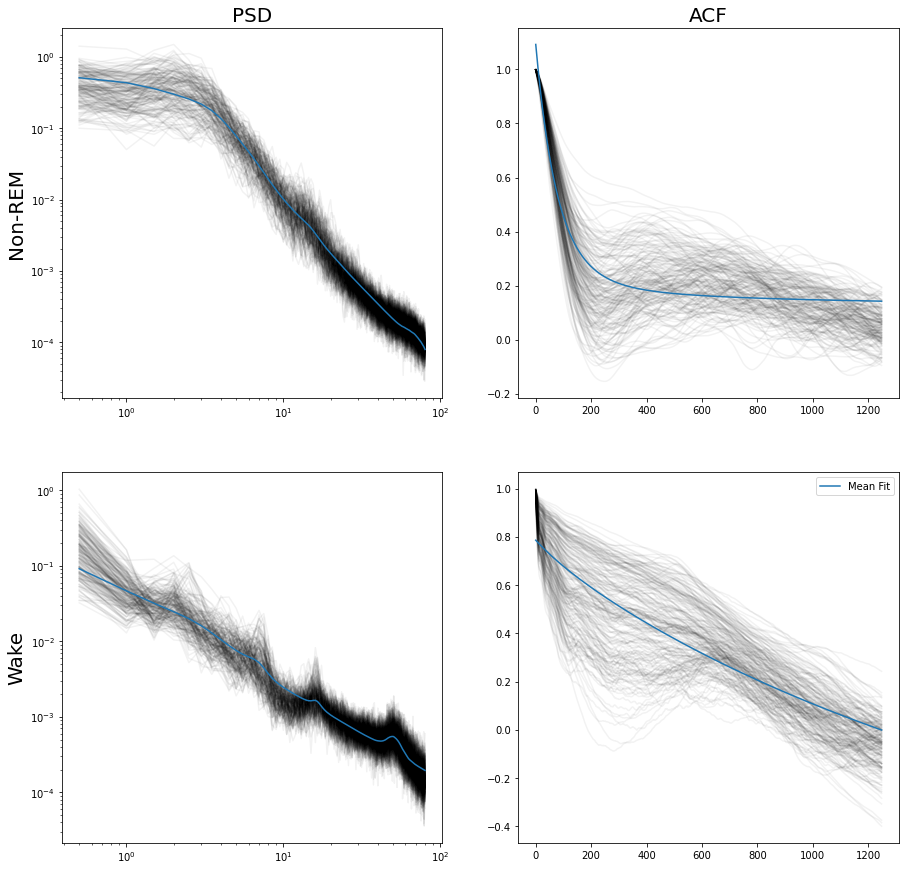

In [9]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)


for _fm in nrem_fms:
    axes[0][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[0][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in nrem_fms]), axis=0),
                color='C0')

for _fm in wake_fms:
    axes[1][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[1][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in wake_fms]), axis=0),
                color='C0')

for i, _acf in enumerate(np.array([i.corrs for i in nrem_acf_class])):
    axes[0][1].plot(_acf, color='k', alpha=.05)
    
axes[0][1].plot(np.mean(np.array([i.corrs_fit for i in nrem_acf_class]), axis=0), color='C0')

for i, _acf in enumerate(np.array([i.corrs for i in wake_acf_class])):
    axes[1][1].plot(_acf, color='k', alpha=.05)
    
axes[1][1].plot(np.mean(np.array([i.corrs_fit for i in wake_acf_class]), axis=0), color='C0', label='Mean Fit')
    
axes[0][0].set_title('PSD', size=20)
axes[0][1].set_title('ACF', size=20)
axes[0][0].set_ylabel('Non-REM', size=20)
axes[1][0].set_ylabel('Wake', size=20)

plt.legend();

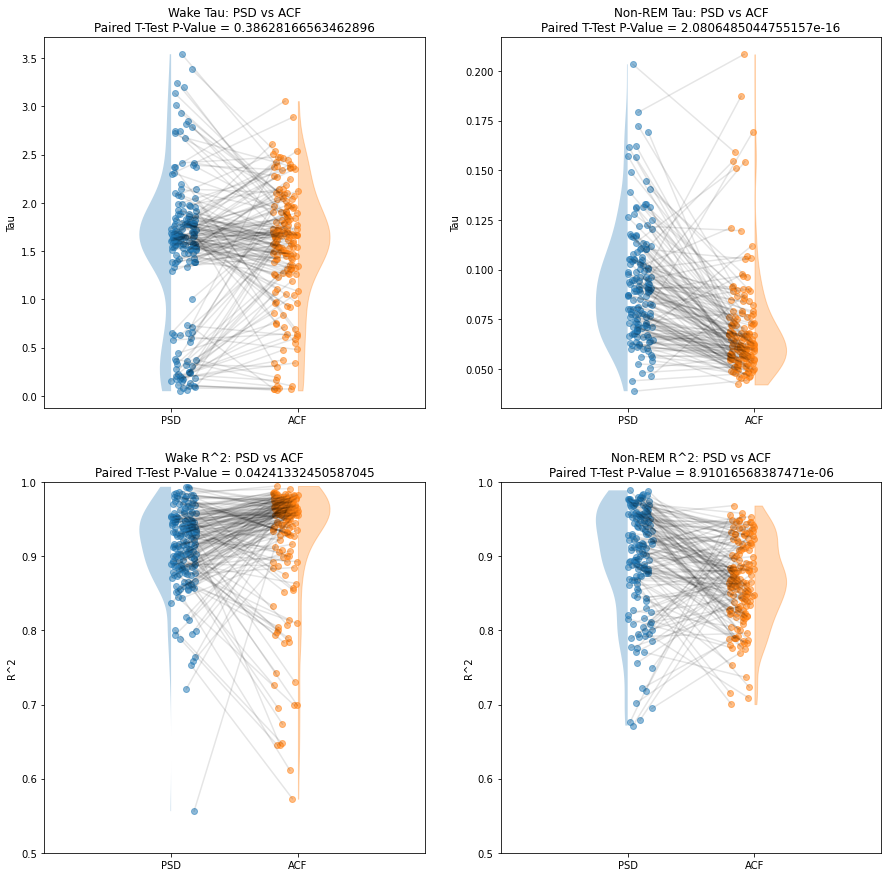

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_keep], wake_taus_acf[wake_keep], axes[0][0], 
                       f'Wake Tau: PSD vs ACF\nPaired T-Test P-Value = {wake_taus_pval}')

plot_connected_scatter(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep], axes[0][1],
                       f'Non-REM Tau: PSD vs ACF\nPaired T-Test P-Value = {nrem_taus_pval}')

plot_connected_scatter(wake_rsq[wake_keep], wake_rsq_acf[wake_keep], axes[1][0],
                       title=f'Wake R^2: PSD vs ACF\nPaired T-Test P-Value = {wake_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2')

plot_connected_scatter(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep], axes[1][1],
                       title=f'Non-REM R^2: PSD vs ACF\nPaired T-Test P-Value = {nrem_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2')

### WIP

I noticed the above ACF for the wake blocks looked strange. It turns out the ACF has a very slow cosine component. To account for this, the code below adds a two step fitting procedure, where a damped oscillation is first fit and removed from the ACF, and a second fit is performed for the exponential decay of the oscillation-free ACF.

In [11]:
from timescales.sim import sim_damped_oscillation, exp_decay_func
from scipy.optimize import curve_fit

def _sim_damped_oscillation(xs, freq, gamma, var_cos, var_cos_exp):
    return sim_damped_oscillation(1, len(xs), freq, gamma, var_cos, var_cos_exp)

def _exp_decay_func(xs, tau, amplitude, offset):
    fs = 1250
    return exp_decay_func(np.arange(1, len(xs)+1), fs, tau, amplitude, offset)

def fit_test(start, sig_lfp=None, fs=None, nlags=None, win_len=None, bounds=None):
    
    if nlags is None:
        nlags = self.fs
        
    corrs = compute_acf(sig_lfp[start:start+win_len], nlags)
    
    osc_bounds = [
        [1, 0, 0, 0],
        [10, 10, 1, 1]
    ]

    cos_params, _ = curve_fit(_sim_damped_oscillation, np.arange(1, len(corrs)+1),
                          corrs, bounds=osc_bounds)
    
    cos_fit = sim_damped_oscillation(1, len(corrs), *cos_params)
    
    bounds = [
        [.0001, 0.001, 0],
        [5, 1, 1]
    ]
    
    cos_rm = corrs - cos_fit
    
    params, _ = curve_fit(_exp_decay_func, np.arange(1, len(corrs)+1), cos_rm, bounds=bounds)
    
    corrs_fit = _exp_decay_func(np.arange(1, len(corrs)+1), *params) + cos_fit
    
    rsq = np.corrcoef(corrs, corrs_fit)[0][1] ** 2
    
    return params[0], rsq, (corrs, corrs_fit)

In [12]:
# ACF
bounds = np.array([[1e-6, None, None],
                   [10, None, None]])

fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, bounds=None,
                  nlags=int(10*fs))

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(fit_test, **fit_kwargs), wake_starts, chunksize=20)
    results_wake_acf = list(tqdm(mapping, total=len(wake_starts), dynamic_ncols=True))
    

fit_kwargs = dict(sig_lfp=sig_lfp, fs=fs, win_len=win_len, bounds=None,
                  nlags=int(10*fs))

with Pool(processes=8) as pool:
    mapping = pool.imap(partial(fit_test, **fit_kwargs), nrem_starts, chunksize=20)
    results_nrem_acf = list(tqdm(mapping, total=len(nrem_starts), dynamic_ncols=True))
    
wake_taus_acf, wake_rsq_acf, wake_acf_class = sort_result(results_wake_acf)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = sort_result(results_nrem_acf)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

In [13]:
# Remove outliers
n_to_keep= round(len(wake_rsq)*.85)
wake_keep = np.argsort(np.abs(wake_taus - wake_taus_acf))[:n_to_keep]

n_to_keep= round(len(nrem_rsq)*.85)
nrem_keep = np.argsort(np.abs(nrem_taus - nrem_taus_acf))[:n_to_keep]

# Run paired t-test
wake_rsq_pval = ttest_rel(wake_rsq[wake_keep], wake_rsq_acf[wake_keep]).pvalue
wake_taus_pval = ttest_rel(wake_taus[wake_keep], wake_taus_acf[wake_keep]).pvalue

nrem_rsq_pval = ttest_rel(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep]).pvalue
nrem_taus_pval = ttest_rel(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep]).pvalue

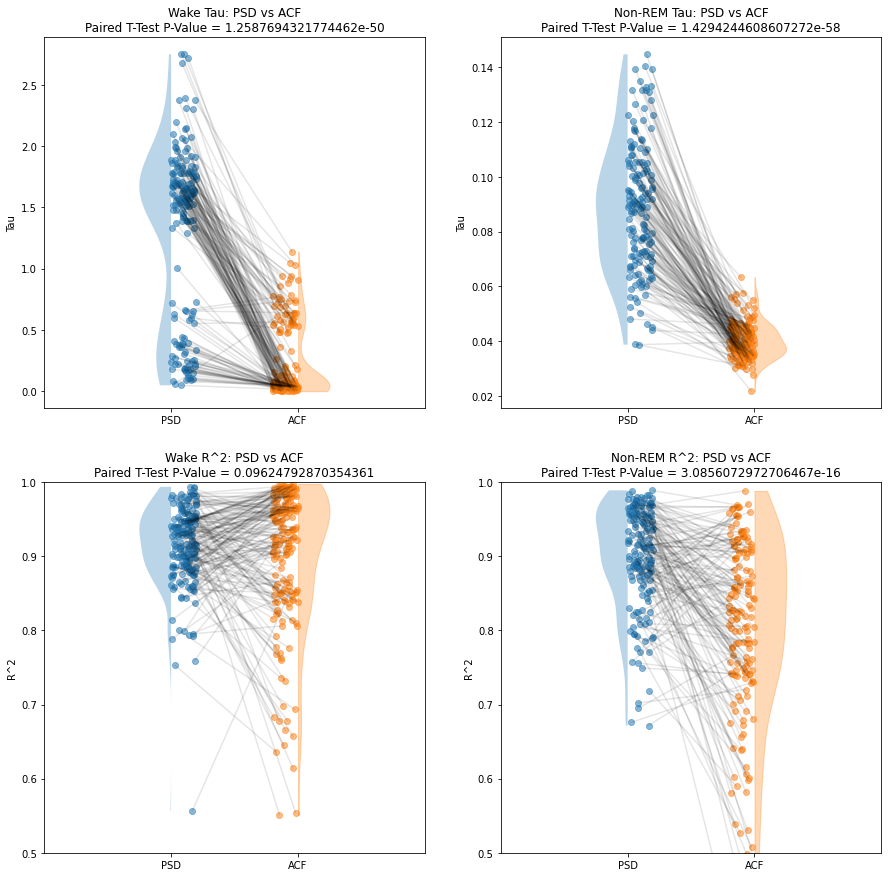

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_keep], wake_taus_acf[wake_keep], axes[0][0], 
                       f'Wake Tau: PSD vs ACF\nPaired T-Test P-Value = {wake_taus_pval}')

plot_connected_scatter(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep], axes[0][1],
                       f'Non-REM Tau: PSD vs ACF\nPaired T-Test P-Value = {nrem_taus_pval}')

plot_connected_scatter(wake_rsq[wake_keep], wake_rsq_acf[wake_keep], axes[1][0],
                       title=f'Wake R^2: PSD vs ACF\nPaired T-Test P-Value = {wake_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2')

plot_connected_scatter(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep], axes[1][1],
                       title=f'Non-REM R^2: PSD vs ACF\nPaired T-Test P-Value = {nrem_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2')

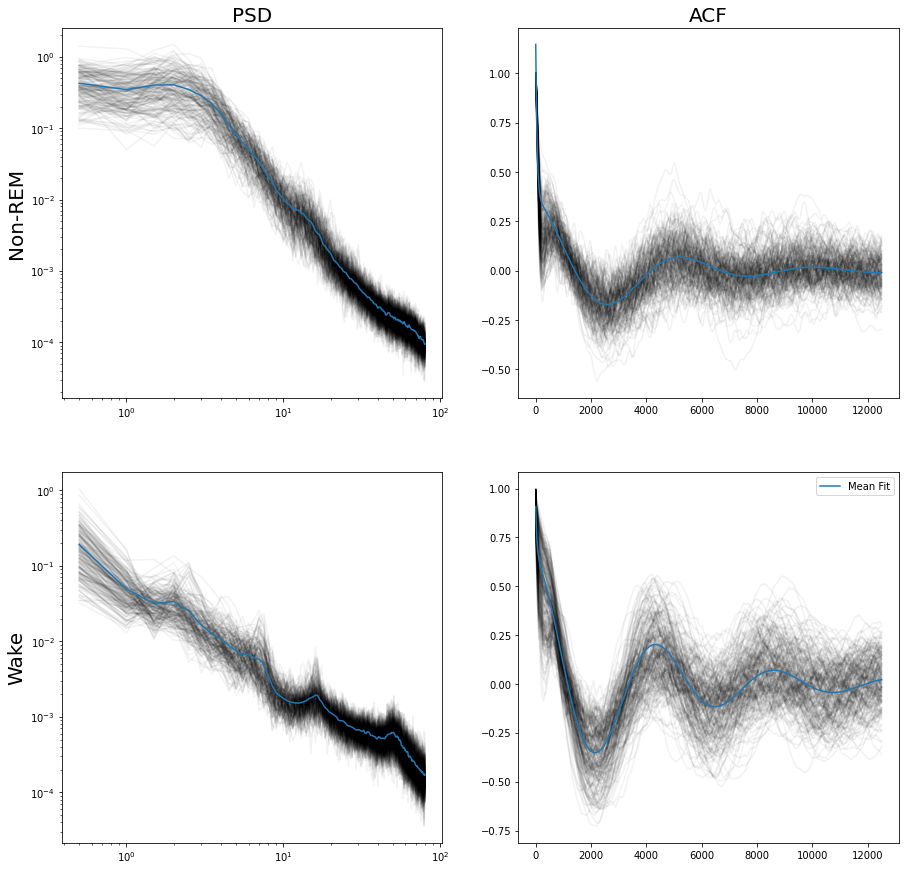

In [15]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)


for _fm in nrem_fms:
    axes[0][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[0][0].plot(_fm.freqs, np.mean(np.array([10**i.power_spectrum for i in nrem_fms]), axis=0),
                color='C0')

for _fm in wake_fms:
    axes[1][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)
    
axes[1][0].plot(_fm.freqs, np.mean(np.array([10**i.power_spectrum for i in wake_fms]), axis=0),
                color='C0')

for i, _acf in enumerate(nrem_acf_class):
    axes[0][1].plot(_acf[0], color='k', alpha=.05)
    
axes[0][1].plot(np.mean(np.array([i[1] for i in nrem_acf_class]), axis=0), color='C0')

for i, _acf in enumerate(wake_acf_class):
    axes[1][1].plot(_acf[0], color='k', alpha=.05)
    
axes[1][1].plot(np.mean(np.array([i[1] for i in wake_acf_class]), axis=0), color='C0', label='Mean Fit')
    
axes[0][0].set_title('PSD', size=20)
axes[0][1].set_title('ACF', size=20)
axes[0][0].set_ylabel('Non-REM', size=20)
axes[1][0].set_ylabel('Wake', size=20)

plt.legend();